# MiniBatch KMeans Clustering and Analysis 

After taking a step back, learning a bit more about NLP and realising my original naive approaches were terrible and riddled with noise, I did some heavy stopword removal. 
This approach involves creating tfidf document vectors. We then apply MiniBatchKMeans to identify clusters. (Note: this is very much an iterative process)

***6*** clusters were chosen as a result of applying silouette score analysis, combined with some of the below analysis techniques and an upper limit to the number of clusters I wanted - due to the size of the data I chose 6.

I also tried to use word2vec implementation in spacy. While word2vec gave more even cluster sizes (not to mention a nicer PCA plot), these clusters had significant overlap and did not identify any key themes. 

Overall the clustering process worked fairly well with some clear traits associated with certain clusters. However, the dense nature of the data definitely resulted in significant overlap (This is obvious from the PCA plot alone). 

In [122]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import MiniBatchKMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import normalize
import seaborn as sns
sns.set_style('darkgrid')
from ast import literal_eval
from nrclex import NRCLex
from wordcloud import WordCloud
import random
import spacy


mast=pd.read_csv('master_stopwords_removed.csv',index_col=0)
df=mast.copy()
df.drop([col for col in df.columns if col!='cleaned_contents'], axis=1, inplace=True)
df.dropna(axis=0, subset=['cleaned_contents'],inplace=True)

In [123]:
#tfidf 
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer(
    min_df = 5,
    max_df = 0.95,
    max_features = 1000,
    stop_words = 'english',
    norm='l2'
)
tfidf.fit(df.cleaned_contents)
tweet_vectors = tfidf.transform(df.cleaned_contents)
tweet_vectors=tweet_vectors.toarray()

The following is the code used for word2vec, which I didn't end up using in the final clustering.

In [111]:
#nlp=spacy.load("en_core_web_lg")
#with nlp.disable_pipes():
 #   tweet_vectors=np.array([nlp(str(tweet.cleaned_contents)).vector for idx, tweet in df.iterrows()])
#tweet_vectors=pd.DataFrame(tweet_vectors, columns=['Component-'+str(i) for i in range(1,301)])

In [112]:
#from sklearn.preprocessing import normalize
#tweet_vectors=normalize(tweet_vectors)

The following plots the silhouette scores for a variety of n_clusters.

Fit 2 clusters
Fit 4 clusters
Fit 6 clusters
Fit 8 clusters
Fit 10 clusters
Fit 12 clusters
Fit 14 clusters
Fit 16 clusters
Fit 18 clusters
Fit 20 clusters


<Figure size 576x576 with 0 Axes>

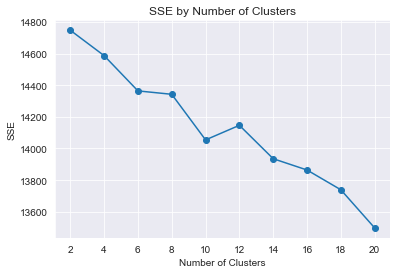

In [125]:
def silhouette_analysis(data, max_k):
    iters = range(2, max_k+1, 2)
    
    sse = []
    for k in iters:
        sse.append(MiniBatchKMeans(n_clusters=k, init_size=1024, batch_size=2048, random_state=42).fit(data).inertia_)
        print('Fit {} clusters'.format(k))
    plt.figure(figsize=(8,8));
    f, ax = plt.subplots(1, 1)
    ax.plot(iters, sse, marker='o')
    ax.set_xlabel('Number of Clusters')
    ax.set_xticks(iters)
    ax.set_xticklabels(iters)
    ax.set_ylabel('SSE')
    ax.set_title('SSE by Number of Clusters');
    
silhouette_analysis(tweet_vectors, 20)

Decreases were not significant with higher numbers and I made the decision to have no more than 6.

In [126]:
#run with 6
N_CLUST=6
clusters = MiniBatchKMeans(n_clusters=N_CLUST, init_size=1024, batch_size=2048, random_state=20).fit_predict(tweet_vectors)
print('Cluster sizes:')
for i in range(N_CLUST):
    print('Cluster '+str(i)+':',len(clusters[clusters==i]))

Cluster sizes:
Cluster 0: 9528
Cluster 1: 1313
Cluster 2: 304
Cluster 3: 537
Cluster 4: 2829
Cluster 5: 776


The following provides a visualisation of the clusters by using principle components analysis to "project" into 2 dimensions.

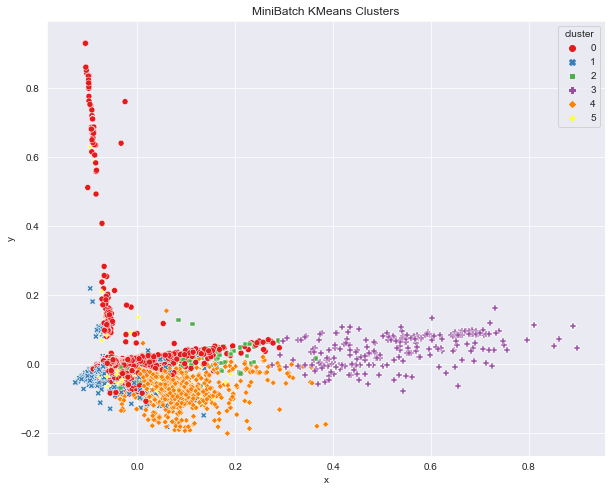

In [127]:
pca=PCA(n_components=2)
pca.fit(tweet_vectors)
pca_vec=pca.transform(tweet_vectors)
pca_vec=pd.DataFrame(pca_vec, columns=['x','y'])
pca_vec['cluster']=clusters
plt.figure(figsize=(10,8))
plt.title('MiniBatch KMeans Clusters')
sns.scatterplot(data=pca_vec, x='x',y='y', hue='cluster',style='cluster', palette='Set1');


# Analysis

In [129]:
mast['contents']=mast['cleaned_contents']
mast.dropna(axis=0, subset=['contents'],inplace=True)
mast['Cluster']=clusters
clust_unique=list(np.unique(clusters))
clusters=clust_unique
df=mast.copy()

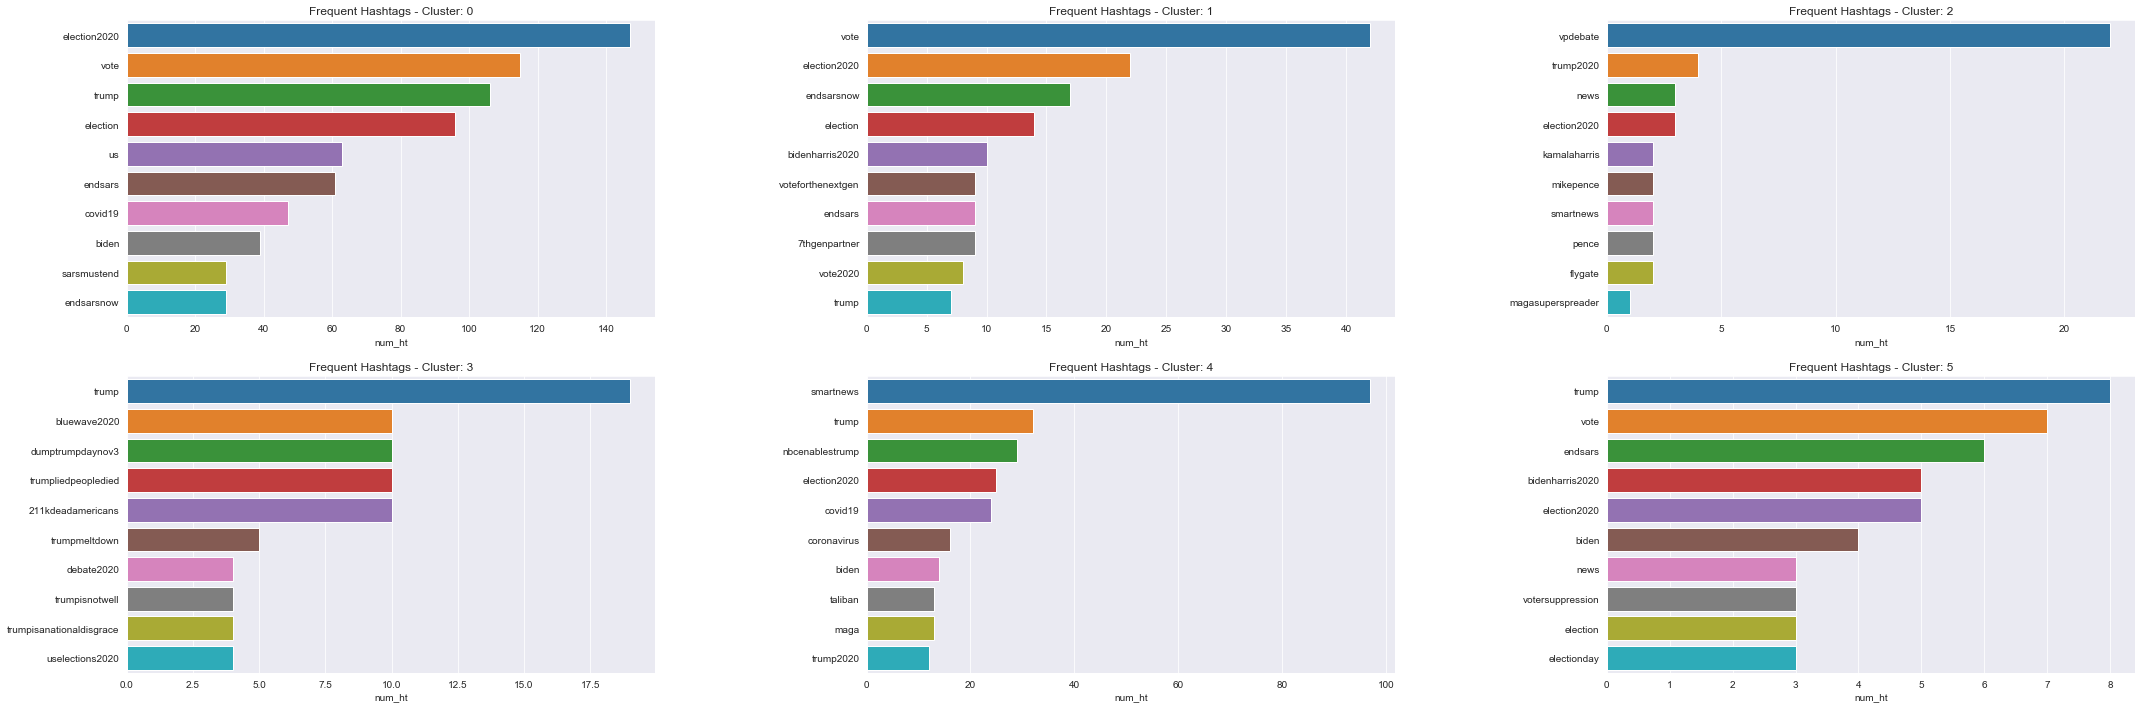

In [132]:
#frequent hashtags
plt.figure(figsize=(6*len(clusters),12))
plt.subplots_adjust(wspace=0.4)
for clust in clusters: 
    df_clust=df[df['Cluster']==clust].copy()
    hashtags_clust=[ht for ht_list in df_clust.hashtag.apply(literal_eval).values for ht in ht_list]
    d_clust=pd.DataFrame.from_dict({ht:hashtags_clust.count(ht) for ht in hashtags_clust}, orient='index', columns=['num_ht'])
    d_clust.sort_values(by='num_ht', ascending=False, inplace=True)
    plt.subplot(2, len(clusters)/2, clusters.index(clust)+1)
    sns.barplot(x=d_clust.iloc[:10].num_ht, y=d_clust.index[:10])
    plt.title('Frequent Hashtags - Cluster: '+str(clust))

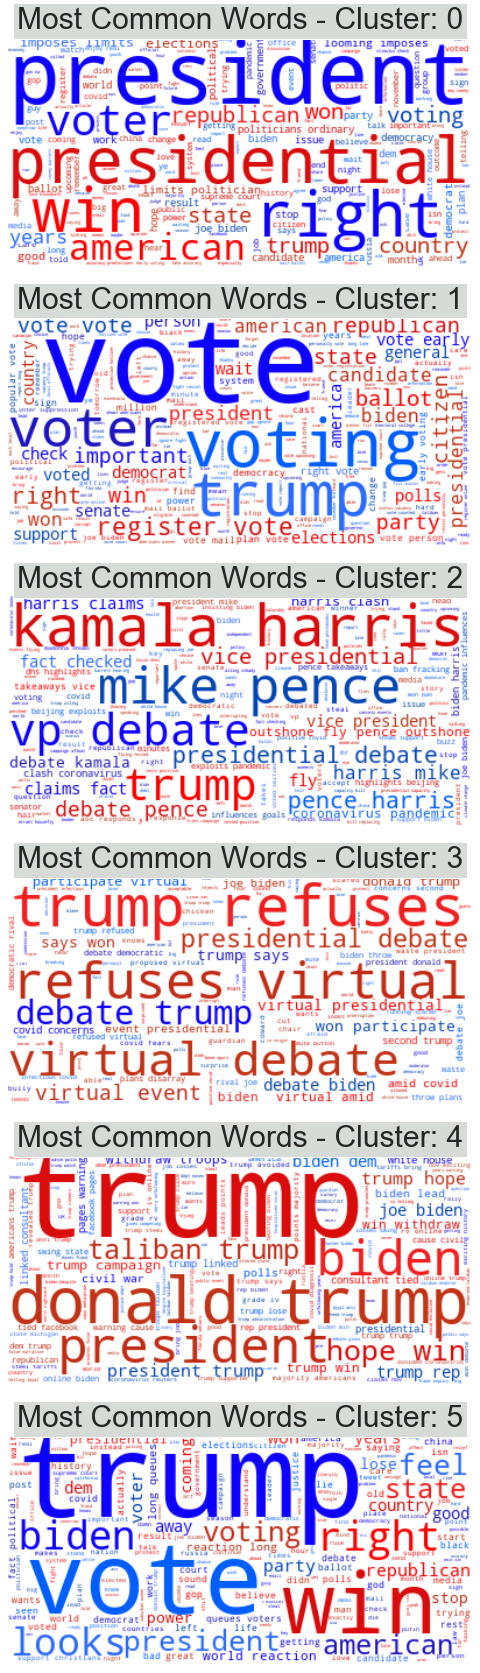

In [121]:
#frequent words
def rb_color(word,font_size,font_path,position,orientation,random_state=None):
    return random.choice(['#f21f1f','#d90b0b','#fc0000','#c22c15','#c23215','#1e15c2','#0d00ff','#005eff','#0546b5','#2b6bff'])

plt.figure(figsize=(20,30))
for clust in clusters:
    all_clust=" ".join(content for content in list(df[df['Cluster']==clust].contents))
    all_clust=all_clust.replace(' us ',' ')
    all_clust=all_clust.replace(' election ', ' ')
    wc_clust=WordCloud(background_color='white', max_font_size=100, max_words=500, random_state=42).generate(all_clust).recolor(color_func=rb_color)
    plt.subplot(len(clusters), 1, clusters.index(clust)+1)
    plt.axis('off')
    plt.imshow(wc_clust, interpolation='bilinear')
    plt.title('Most Common Words - Cluster: '+str(clust), fontdict={'fontsize':30},bbox={'facecolor':'#d7dbd8','ec':'white'})

The wordclouds show some fairly consistent trends within the clusters. Particularly interesting are cluster 1, picking up the tweets urging people to vote, and cluster 2, picking up those tweets focused more on the vice-presidential race. Unfortunately it doesn't look like there was obvious seperation between pro-biden and pro-trump tweets.

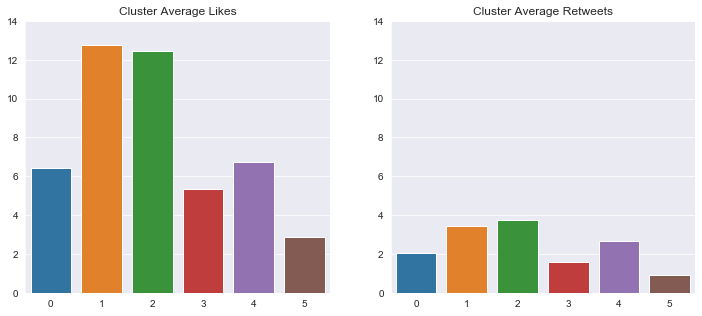

In [133]:
#likes and retweets
likes, retweets=[],[]
for clust in clusters:
    likes.append(df[df['Cluster']==clust].likes.mean())
    retweets.append(df[df['Cluster']==clust].retweets.mean())
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.ylim(top=int(max(max(likes),max(retweets))+2))
plt.title('Cluster Average Likes')
sns.barplot(x=clusters, y=likes)

plt.subplot(1,2,2)
plt.ylim(top=int(max(max(likes),max(retweets))+2))
plt.title('Cluster Average Retweets')
sns.barplot(x=clusters, y=retweets);

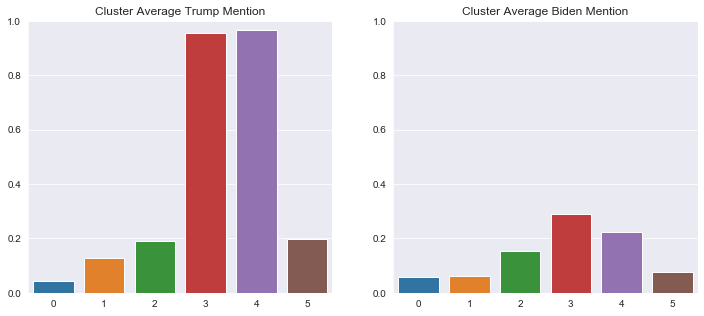

In [134]:
#average trump/biden mention

df['trump_mention']=df['contents'].apply(lambda x: int('trump' in x))
df['biden_mention']=df['contents'].apply(lambda x: int('biden' in x))
trump_mentions=[(df[df['Cluster']==clust].trump_mention.sum())/df[df['Cluster']==clust].shape[0] for clust in clusters]
biden_mentions=[(df[df['Cluster']==clust].biden_mention.sum())/df[df['Cluster']==clust].shape[0] for clust in clusters]
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.title('Cluster Average Trump Mention')
plt.ylim(top=1)
sns.barplot(x=clusters, y=trump_mentions)

plt.subplot(1,2,2)
plt.title('Cluster Average Biden Mention')
plt.ylim(top=1)
sns.barplot(x=clusters, y=biden_mentions);

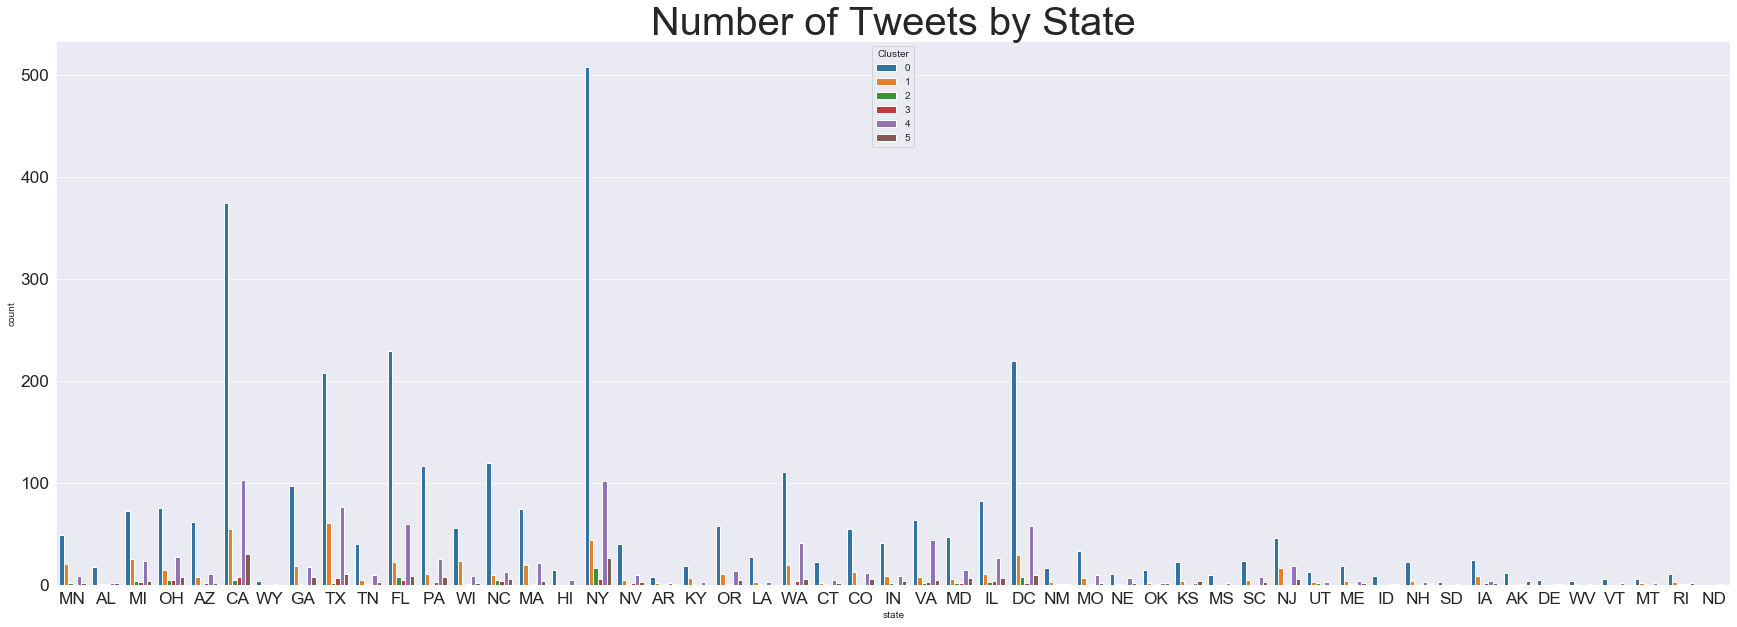

In [135]:
#locations
states=['AL','AK','AZ','AR','CA','CO','CT','DE','DC','FL','GA','HI','ID','IL','IN','IA','KS','KY','LA','ME', \
       'MD','MA','MI','MN','MS','MO','MT','NE','NV','NH','NJ','NM','NY','NC','ND','OH','OK','OR','PA','RI',\
       'SC','SD','TN','TX','UT','VT','VA','WA','WV','WI','WY']
states_full=['Alabama', 'Alaska', 'Arizona', 'Arkansas', 'California', 'Colorado', 'Connecticut', 'Delaware', 
             'District of Columbia','Florida', 'Georgia', 'Hawaii', 'Idaho', 'Illinois', 'Indiana', 'Iowa', 
             'Kansas', 'Kentucky', 'Louisiana', 'Maine', 'Maryland', 'Massachusetts', 'Michigan', 'Minnesota', 
             'Mississippi', 'Missouri', 'Montana', 'Nebraska', 'Nevada', 'New Hampshire', 'New Jersey', 'New Mexico',
             'New York', 'North Carolina', 'North Dakota', 'Ohio', 'Oklahoma', 'Oregon', 'Pennsylvania', 'Rhode Island',
             'South Carolina', 'South Dakota', 'Tennessee', 'Texas', 'Utah', 'Vermont', 'Virginia', 'Washington', 
             'West Virginia', 'Wisconsin', 'Wyoming']

def get_state(place):
    for state in states:
        try:
            if ' '+state in place:
                return state
        except TypeError:
            continue
    for state in states_full:
        try:
            if state in place:
                return states[states_full.index(state)]
        except TypeError:
            continue
    return None

df['state']=df['location'].apply(get_state)
plt.figure(figsize=(30,10))
plt.xticks(fontsize='xx-large')
plt.yticks(fontsize='xx-large')
plt.title('Number of Tweets by State', fontsize=40)
sns.countplot(data=df, x='state', hue='Cluster');

# Conclusion

It is clear, mostly from the wordclouds, that the algorithm identified some clusterability. How valuable these clusters may be was not determined with the analytical techniques we used and it is clear that there was a lot of overlap. It is likely we would have benefitted from applying more NLP techniques such as lemmatisation while also extracting further features using a "rule-based" approach.